# A word2vec approach with `gensim`

What's `word2vec`?
Roughly speaking, it's a shallow neural network model
that can be trained to create a word embedding for NLP.
There are two architectures:

* Continuous BoW (Bag of Words),
  this one tries to predict a word given the context;
* Continuous skip-gram,
  this one tries to predict the context from a given word.

Here we'll use `gensim` again, it's an open source library
that was created as part of the
[Radim Řehůřek's Ph.D. Thesis](
  https://radimrehurek.com/phd_rehurek.pdf
), *Scalability of semantic analysis
    in natural language processing*, 2011.
His thesis is mainly towards LSA (Latent Semantic Analysis),
and LDA (Latent Dirichlet Allocation).
However, `word2vec` was published after that,
by Tomas Mikolov, Kai Chen, Greg Corrado and Jeffrey Dean
(a team of Google researchers),
in the *Efficient Estimation of
        Word Representations in Vector Space*, 2013
\[[PDF](https://arxiv.org/pdf/1301.3781.pdf),
  [C++ code](https://code.google.com/archive/p/word2vec/)\].
Radim Řehůřek himself added `word2vec` to his `gensim` library,
and published a [short tutorial for it](
  https://rare-technologies.com/word2vec-tutorial/
).

## Wikipedia trigram model

For a first try of `word2vec` in \[Brazilian\] Portuguese,
one can see the Felipe Parpinelli's
[word2vec-pt-br](https://github.com/felipeparpinelli/)
repository (unfortunately, only available for Python 2).
However, [he trained a trigram vector model and published it](
  https://drive.google.com/file/d/0B_eXEo_eUPCDWnJ0YWtUdW1kVFk/view
),
so we can directly use here in Python 3.7 with `gensim`.
The model is a 2GB file whose SHA256 is
`5421465d49a5f709f81cec3607c64b1e6a0724fdce94f9d507a48fe07f95d098`.

In [1]:
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd

In [2]:
wiki_model = KeyedVectors.load_word2vec_format("wiki.pt.trigram.vector", binary=True)

It has a vocabulary of more than one million words and expressions,
all in lower case, with underscores as separators:

In [3]:
len(wiki_model.vocab)

1264918

### Word similarity and "maths with words"

As of today, in the cited repository,
Parpinelli is only using two model methods:
`most_similar` and `doesnt_match`.
The first one can be used to find similar words,
with a similarity measurement
ranging from $0$ to $1$.
This example shows the name of cities
in the São Paulo state, Brazil,
given the name of one city:

In [4]:
wiki_model.most_similar("campinas")

/usr/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('ribeirão_preto', 0.7867798805236816),
 ('sorocaba', 0.7684873342514038),
 ('jundiaí', 0.7378007173538208),
 ('araraquara', 0.7296241521835327),
 ('são_paulo', 0.7239118814468384),
 ('guarulhos', 0.7190227508544922),
 ('bauru', 0.708629310131073),
 ('botucatu', 0.6960499882698059),
 ('taubaté', 0.6935198307037354),
 ('mogi_das_cruzes', 0.6845329403877258)]

These are the words
that have the highest similarity with `campinas`.
Such list of tuples can be easily converted
to a Pandas dataframe:

In [5]:
pd.DataFrame(
    wiki_model.most_similar("campinas"),
    columns=["token", "similarity"],
).set_index("token")

,similarity
token,
ribeirão_preto,0.786780
sorocaba,0.768487
jundiaí,0.737801
araraquara,0.729624
são_paulo,0.723912
guarulhos,0.719023
bauru,0.708629
botucatu,0.696050
taubaté,0.693520


As we're trying to predict the context vector from a word,
what this gives is that
all these words can easily appear in the same contexts.
Though the training process of `word2vec` is unsupervised
(it's a dimensionality reduction algorithm)


Instead of a single word,
we can also give a list of *positive* and *negative* words,
performing something akin to this math:

$$
\begin{array}{cll}
{}   & Brasília & \text{# federal capital of Brazil} \\
{} - & Brasil   & \text{# Brazil, in Brazilian Portuguese} \\
{} + & Alemanha & \text{# Germany, in Brazilian Portuguese} \\ \hline
{}   & ???
\end{array}
$$

In [6]:
wiki_model.most_similar(
    positive=["brasilia", "alemanha"],
    negative=["brasil"],
    topn=1,
)

[('berlin', 0.5845881104469299)]

The typical "equation" is $king - man + woman$,
the first example in the 2013 paper,
which here also yields $queen$
(but with all the words in Brazilian Portuguese):

In [7]:
wiki_model.most_similar(
    positive=["rei", "mulher"], # ["king", "woman"]
    negative=["homem"],         # ["man"]
    topn=1,
)

[('rainha', 0.6084680557250977)]

### Word vector normalization

We can also get the vector regarding a word to make some actual maths with it:

In [8]:
type(wiki_model["brasilia"])

numpy.ndarray

In [9]:
wiki_model["brasilia"].shape

(400,)

But in this case, using the `similar_by_vector` method,
we need to manually remove the similarity with itself:

In [10]:
wiki_model.similar_by_vector(wiki_model["campinas"], topn=5)

[('campinas', 1.0),
 ('ribeirão_preto', 0.7867798805236816),
 ('sorocaba', 0.7684873342514038),
 ('jundiaí', 0.7378007769584656),
 ('araraquara', 0.7296241521835327)]

And performing the maths doesn't result in the same vectors,
as not all vectors will have the same weight:

In [11]:
pd.DataFrame(
    wiki_model.similar_by_vector(
        wiki_model["brasilia"] - wiki_model["brasil"] + wiki_model["alemanha"],
        topn=10,
    ),
    columns=["token", "similarity"],
).set_index("token")

,similarity
token,
magdeburg,0.542283
erfurt,0.525711
krefeld,0.520014
alta_baviera,0.517179
aachen,0.516245
freiburg,0.516041
baixa_saxónia,0.508358
salzburg,0.506056
ulm,0.505461


In [12]:
pd.DataFrame(
    wiki_model.similar_by_vector(
        wiki_model["rei"] - wiki_model["homem"] + wiki_model["mulher"],
        topn=10,
    ),
    columns=["token", "similarity"],
).set_index("token")

,similarity
token,
rei,0.713224
rainha,0.626994
consorte,0.553226
rainha_viúva,0.531954
mulher,0.513182
rainha_consorte,0.508050
rainha_isabel,0.507507
monarca,0.502872
princesa,0.501628


That's because the vector magnitude is way too different,
and we care mostly about the vector direction,
not the vector magnitude.
Let's calculate the vector magnitude/norm
for each of these words:

In [13]:
{k: np.sqrt((wiki_model[k] ** 2).sum())
 for k in ["brasilia", "brasil", "alemanha"]}

{'brasilia': 9.4632, 'brasil': 28.960426, 'alemanha': 24.099485}

In [14]:
{k: np.sqrt((wiki_model[k] ** 2).var())
 for k in ["rei", "homem", "mulher"]}

{'rei': 2.9873471, 'homem': 2.229483, 'mulher': 2.2330337}

To give the same weight to these vectors,
we need to normalize them before doing that sum/subtraction math.
We can simply divide the vectors by the numbers above (their norm),
but that's already done by the `word_vec` method
when `use_norm=True`:

In [15]:
(wiki_model.word_vec("rei", use_norm=True) ** 2).sum()

1.0

Calculating the most similar vectors again
(using the direction, not the magnitude):

In [16]:
pd.DataFrame(
    wiki_model.similar_by_vector(
          wiki_model.word_vec("brasilia", True)
        - wiki_model.word_vec("brasil", True)
        + wiki_model.word_vec("alemanha", True),
        topn=10,
    ),
    columns=["token", "similarity"],
).set_index("token")

,similarity
token,
berlin,0.584588
hamburg,0.580028
salzburg,0.579465
münchen,0.572176
freiburg,0.571325
sinsheim,0.562500
köln,0.561137
nürnberg,0.560043
krefeld,0.559181


In [17]:
pd.DataFrame(
    wiki_model.similar_by_vector(
          wiki_model.word_vec("rei", True)
        - wiki_model.word_vec("homem", True)
        + wiki_model.word_vec("mulher", True),
        topn=10,
    ),
    columns=["token", "similarity"],
).set_index("token")

,similarity
token,
rei,0.656337
rainha,0.608468
consorte,0.547408
mulher,0.534614
rainha_viúva,0.525085
esposa,0.499288
rainha_consorte,0.498275
princesa,0.494415
rainha_isabel,0.493366


That's what the `most_similar` method does,
and it's also what the original *word2vec* implementation does,
as the method documentation states:

> The method corresponds to the `word-analogy` and `distance` scripts
> in the original word2vec implementation.

As an explanation of the maths,
we're looking for a vector $b^*$ that maximizes $b^* \cdot (b - a + a^*)$,
working with unit-length vectors $b$, $a$ and $a^*$
that corresponds to the input words.
That can also be written as a maximization of
$b^* \cdot b - b^* \cdot a + b^* \cdot a^*$,
or, defining a binary operator $\cos$ as the cosine similarity
(dot product divided by the norms of each vector), we can write it as:

$$\arg \max_{b^*} \cos(b^*, b) - \cos(b^*, a) + \cos(b^*, a^*)$$

### Alternative similarity formula

Omer Levy and Yoav Goldberg, in
*Linguistic Regularities in Sparse and Explicit Word Representations*, 2014
\[[PDF](http://www.aclweb.org/anthology/W14-1618)\],
named as *3CosAdd* the similarity algorithm we've just seen,
and they proposed an alternative "multiplicative" algorithm called *3CosMul*,
that reminds us of applying the c of each addend/subtrahend
in the "sum/subtraction of cosine similarities" function we were maximizing.
This new equation can also be seen as something like
taking a geometric mean of the terms, instead of a simple average.

$$
\arg \max_{b^*} \dfrac{\cos(b^*, b) \cos(b^*, a^*)}
                      {\cos(b^*, a) + \varepsilon}
$$

That's exactly what the `most_similar_cosmul` method does!

In [18]:
wiki_model.most_similar_cosmul(
    positive=["brasilia", "alemanha"],
    negative=["brasil"],
    topn=10,
)

[('frankfurt_oder', 0.9992457628250122),
 ('hamburg', 0.9958572387695312),
 ('salzburg', 0.993118941783905),
 ('magdeburg', 0.979534387588501),
 ('krefeld', 0.9781520962715149),
 ('oberhausen', 0.9737989902496338),
 ('zürich', 0.9721503853797913),
 ('budapest', 0.9673693776130676),
 ('berlin', 0.9658992290496826),
 ('vienna', 0.9648484587669373)]

In [19]:
wiki_model.most_similar_cosmul(
    positive=["rei", "mulher"],
    negative=["homem"],
    topn=10,
)

[('rainha', 0.9783447980880737),
 ('consorte', 0.9311118721961975),
 ('rainha_viúva', 0.9254377484321594),
 ('rainha_consorte', 0.9043235778808594),
 ('rainha_isabel', 0.8911893963813782),
 ('rainha_regente', 0.8879780173301697),
 ('infanta', 0.8857831358909607),
 ('princesa', 0.8801829814910889),
 ('rainha_reinante', 0.8782250881195068),
 ('concubina', 0.8746837377548218)]

It kept *rainha* (queen) as the most similar word
in the $king - man + woman$ equation,
but *berlin* (Berlin) is no longer the most similar word
in the $Brasília - Brazil + Germany$ equation.
The similarity values are way higher,
but Vienna is the federal capital of Austria,
it's no longer a city in Germany.
In some sense, these $2$ cherry-picked examples
aren't better in *3CosMul* than in *3CosAdd*,
that suffices for us to avoid dropping any of these.

### Lack of data cleaning

We've found that some words aren't properly cleaned in the input,
and that might rule out what we would expect
with "words maths" like the ones previously performed here.
An example is the word *frequency*,
which in portuguese is *frequência*,
yet it appear in the dataset with some different writings:

In [20]:
wiki_model.similar_by_vector(wiki_model["frequência"], topn=5)

[('frequência', 1.0),
 ('freqüência', 0.8619202971458435),
 ('frequencia', 0.6580279469490051),
 ('amplitude', 0.6013369560241699),
 ('frequências', 0.6001715660095215)]

The $frequency - hertz + seconds$ equation
is expected to return something like *period*, *duration* or *time*,
but none of these appears as the $5$ most similar words/expressions:

In [21]:
wiki_model.most_similar(
    positive=["frequência", "segundos"],
    negative=["hertz"],
    topn=5,
)

[('cinco_minutos', 0.5157788991928101),
 ('minutos', 0.5141439437866211),
 ('freqüência', 0.506064772605896),
 ('dez_minutos', 0.47891607880592346),
 ('cada_vez', 0.47068893909454346)]

Translation of each result, in order:

- Five minutes
- Minutes
- Frequency (another writing of the same word)
- Ten minutes
- Each time/turn/cycle
  (*vez* have nothing to do with the physical meaning of *time*)

The fifth entry have something to do with the idea of a cycle,
but the word *frequency* appeared again,
and it's strange to see these time durations in minutes
as distinct tokens.
Using *3CosMul* doesn't help that much,
its new entries are *do* (of) and *já* (already / right now):

In [22]:
wiki_model.most_similar_cosmul(
    positive=["frequência", "segundos"],
    negative=["hertz"],
    topn=5,
)

[('do', 0.9138926267623901),
 ('já', 0.9123607873916626),
 ('cinco_minutos', 0.9002106785774231),
 ('cada_vez', 0.890281081199646),
 ('minutos', 0.8871634006500244)]

An expected result was *período*,
but there are entries with:

- A missed acute accent
- A typo (perído)

In [23]:
wiki_model.similar_by_vector(wiki_model["período"], topn=5)

[('período', 1.0),
 ('periodo', 0.7241699695587158),
 ('perído', 0.6035453081130981),
 ('longo_período', 0.5876239538192749),
 ('períodos', 0.5766887068748474)]

And these are obviously not the only words
that hadn't been properly cleaned.
Perhaps the result wasn't as expected
in the last "word math" calculation
because of this "word splitting",
though there's no reason to believe
that these alternative writings have some systematic bias.

In [24]:
wiki_model.similar_by_vector(wiki_model["periodo"], topn=5)

[('periodo', 1.0000001192092896),
 ('período', 0.7241699695587158),
 ('perído', 0.7190518379211426),
 ('conturbado_período', 0.6516879200935364),
 ('interregno', 0.6100722551345825)]

(Floats are evil:
 the sums going on behind the scenes
 aren't free from rounding issues,
 that's why the similarity of a word with itself
 was given as greater than one).

## Training a `word2vec` model

How could a `word2vec` model replace an LSI model
to create a word embedding
that would be helpful on
either finding invalid/inconsistent entries
or filling missing values
on a dataset of document affiliations?

Let's perform the same procedure applied on LSI in the previous experiment,
but, this time, let's use it to train a word2vec model.

The goal is to:

- Fit a `word2vec` model with the CSV created on 2018-06-04,
  ignoring the country fields;
- Fit a random forest model to detect the country from the `word2vec` vectors.

### Simple/small example data

Let's use the `gensim` word list example:

In [25]:
from gensim.test.utils import common_texts
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

Training the model is quite straightforward.

In [26]:
from gensim.models import Word2Vec
simple_model = Word2Vec(common_texts,
    size=100,
    window=5,
    min_count=1, # Don't ignore rare words
    sg=1, # Skip-gram architecture
    workers=4,
)

The embedded vectors are stored as a numpy array:

In [27]:
print(simple_model.wv.vectors.shape)
simple_model.wv.vectors

(12, 100)


array([[-0.00429325, -0.00053441, -0.00069498, ..., -0.00280878,
        -0.00281088,  0.00136091],
       [ 0.00264861, -0.00271103, -0.00236115, ..., -0.00461583,
         0.00246741, -0.00283012],
       [-0.00305232,  0.00020281, -0.00423114, ..., -0.00494703,
        -0.00124028,  0.00197053],
       ...,
       [ 0.0021847 , -0.00360832, -0.00217316, ..., -0.0048031 ,
        -0.00139142, -0.00275932],
       [-0.0002061 ,  0.00336424, -0.00263451, ...,  0.00407349,
         0.00052204, -0.00373554],
       [ 0.00118459,  0.00014319, -0.00420273, ..., -0.00492786,
         0.00173646,  0.00473093]], dtype=float32)

The words to which the each row belongs are stored in the `index2word` list:

In [28]:
simple_model.wv.index2word

['system',
 'user',
 'trees',
 'graph',
 'human',
 'interface',
 'computer',
 'survey',
 'response',
 'time',
 'eps',
 'minors']

Checking the order:

In [29]:
np.all(simple_model.wv.vectors ==
       np.array([simple_model.wv[word]
                 for idx, word in enumerate(simple_model.wv.index2word)])
      )

True

That information should be enough
for us to create a model with the actual data.

### Getting the word lists and training `word2vec` w/ non-country text fields from Clea's CSV

We'll work with the same dataset
(coming from Clea's output, created on 2018-06-04)
as the previous regarding LSI/LSA (it started on 2018-08-23):

In [30]:
dataset = pd.read_csv("inner_join_2018-06-04.csv",
                      dtype=str,
                      keep_default_na=False) \
            .drop_duplicates()

The first cleaning step is the same one from that experiment,
which removes accents (keeping the letters), lowercases everything
and removes any other character.

In [31]:
import re
from unidecode import unidecode

TEXT_ONLY_REGEX = re.compile("[^a-zA-Z ]")

def pre_normalize(name):
    return TEXT_ONLY_REGEX.sub("", unidecode(name).lower())

Using the same stopwords as before, we can create a function
that gets a dataset and casts it as a word list.
Here we don't need to worry about uncommon (single occurrence) words,
that's a `word2vec` parameter.

In [32]:
stop_words = ["da", "de", "desta", "do", "em", "ii", "iii", "in", "mesma", "no", "pela", "pelos"]

def df2wlist(dset, stop_words=stop_words):
    return dset.T.apply(
        lambda row: [
            word for word in pre_normalize(" ".join(row)).split()
                 if word not in stop_words
                 and len(word) > 1
        ]
    )

The following entries are all the field names from that CSV
with some content that might be useful for us
from which we want to find the `addr_country_code`.
When training with a joined-columns word list,
the order of the fields matters!

In [33]:
x_fields = [
    "addr_city",
    "addr_state",
    "aff_text",
    "article_title",
    "contrib_bio",
    "contrib_prefix",
    "contrib_name",
    "contrib_surname",
    "institution_orgdiv1",
    "institution_orgdiv2",
    "institution_orgname",
    "institution_orgname_rewritten",
    "institution_original",
    "institution_orgname_rewritten",
    "journal_title",
    "publisher_name",
]

From this, we can get the desired wordlist:

In [34]:
%%time
wlist = df2wlist(dataset[x_fields])

CPU times: user 14.6 s, sys: 115 ms, total: 14.7 s
Wall time: 14.7 s


In [35]:
wlist.tail()

94655    [universidade, estado, rio, janeiro, instituto...
94656    [ciudad, buenos, aires, ciudad, buenos, aires,...
94657    [joao, pessoa, pb, universidade, federal, para...
94658    [sao, paulo, universidade, sao, paulo, departa...
94659    [campinas, sp, universidade, estadual, campina...
dtype: object

In [36]:
%%time
model = Word2Vec(wlist,
    size=200,
    window=7,
    min_count=2, # Ignore uncommon words
    sg=1, # Skip-gram architecture
)

CPU times: user 5min 45s, sys: 429 ms, total: 5min 46s
Wall time: 1min 57s


That was really fast!

Although the `word2vec` neural network model is shallow,
the data we've got here might be too small.
Anyway, we know how to compare words,
but we still doesn't know how to compare documents.

## Using the `word2vec` model to calculate the similarity of documents

At first, lest's try to compare pairs of documents in the simple model,
then we'll try to generalize the similarity equations
to train machine learning algorithms
using the `word2vec` embedding.

### Soft cosine similarity in the simple example

The word2vec gives us a *word* embedding vector space model,
not a *document* embedding one.
Let's try one approach to query for similar documents in a corpus
using the `word2vec` embeddings together with a bag of words model,
based on [this tutorial](
  https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/soft_cosine_tutorial.ipynb
).

In [37]:
from gensim.corpora import Dictionary
from gensim.matutils import softcossim, corpus2dense
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

We build a similarity matrix for the words.
It can be seen as a matrix to transform a bag of words vector
into a linear space where the axis for similar words
have stronger projections.

/usr/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


<12x12 sparse matrix of type '<class 'numpy.float32'>'
	with 66 stored elements in Compressed Sparse Column format>

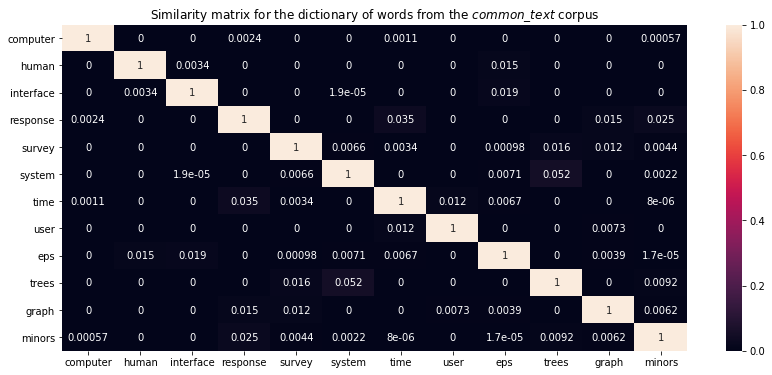

In [38]:
simple_dictionary = Dictionary(common_texts)
simple_similarity_matrix = simple_model.wv.similarity_matrix(simple_dictionary)
sns.heatmap(
    simple_similarity_matrix.todense(),
    annot=True,
    ax=plt.subplots(figsize=(14, 6))[1],
    xticklabels=simple_dictionary.values(),
    yticklabels=simple_dictionary.values(),
).set(title="Similarity matrix for the dictionary of words from the $common\_text$ corpus")
simple_similarity_matrix

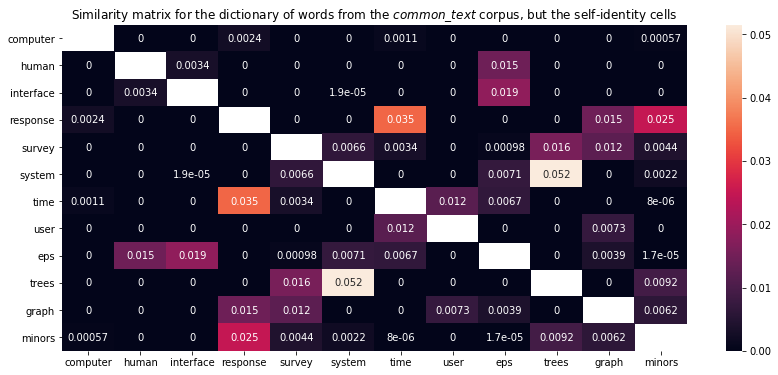

In [39]:
sns.heatmap(
    simple_similarity_matrix.todense() - np.eye(12),
    mask=np.eye(12),
    annot=True,
    ax=plt.subplots(figsize=(14, 6))[1],
    xticklabels=simple_dictionary.values(),
    yticklabels=simple_dictionary.values(),
).set(title="Similarity matrix for the dictionary of words from the $common\_text$ corpus, "
            "but the self-identity cells");

It's always a symmetric matrix,
since the similarity of words $a$ and $b$
and the similarity of words $b$ and $a$
are just the same.

In [40]:
simple_similarity_matrix.T != simple_similarity_matrix

<12x12 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>

With that matrix,
we can compute the similarity between any pair of documents,
based on the bag of words (BoW) vector of both documents.

In [41]:
sysattack_msg = "the computer system is under attack"
sysattack_bow = simple_dictionary.doc2bow(sysattack_msg.split())
softcossim(sysattack_bow,
           simple_dictionary.doc2bow("this survey interface have some minors".split()),
           simple_similarity_matrix)

0.0038064184318746474

In [42]:
softcossim(sysattack_bow,
           simple_dictionary.doc2bow("our trees aren't in the system".split()),
           simple_similarity_matrix)

0.5127219928883727

In [43]:
# This one is compared with a corpus entry
softcossim(sysattack_bow,
           simple_dictionary.doc2bow("survey user computer system response time".split()),
           simple_similarity_matrix)

0.5745107358825415

We can compute the similarity of an arbitrary document
with all documents in a corpus
from the bag of words vectors.

In [44]:
from gensim.similarities import SoftCosineSimilarity

In [45]:
simple_bow_corpus = [simple_dictionary.doc2bow(document) for document in common_texts]
simple_bow_dense = corpus2dense(simple_bow_corpus, num_terms=len(simple_dictionary))
sysattack_bow_vect = corpus2dense([sysattack_bow], num_terms=len(simple_dictionary))

(12, 9)

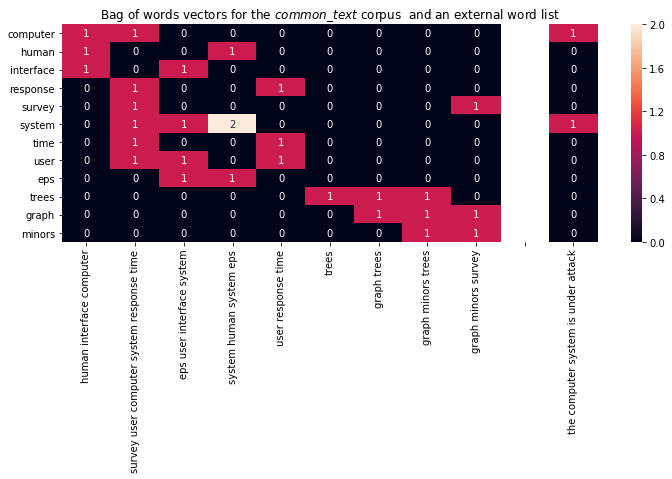

In [46]:
sns.heatmap(
    np.concatenate([simple_bow_dense,
                    np.zeros_like(sysattack_bow_vect),
                    sysattack_bow_vect],
                    axis=1),
    mask=np.concatenate([np.zeros_like(simple_bow_dense),
                         np.ones_like(sysattack_bow_vect),
                         np.zeros_like(sysattack_bow_vect)],
                         axis=1),
    annot=True,
    ax=plt.subplots(figsize=(12, 4))[1],
    xticklabels=[" ".join(wlist) for wlist in common_texts] +
                ["", sysattack_msg],
    yticklabels=[simple_dictionary.id2token[k] for k in range(len(simple_dictionary))],
).set(title="Bag of words vectors for the $common\_text$ corpus "
            " and an external word list")
simple_bow_dense.shape # Each column is a document

In [47]:
simple_scs = SoftCosineSimilarity(simple_bow_corpus, simple_similarity_matrix)
sysattack_similarities = simple_scs[sysattack_bow]
sysattack_similarities

array([0.40779744, 0.57451074, 0.35381804, 0.57664342, 0.00142216,
       0.03644101, 0.02576769, 0.02205062, 0.00377552])

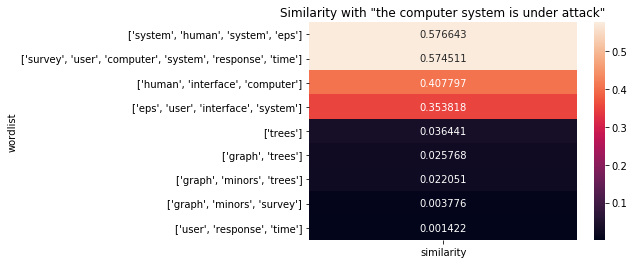

In [48]:
sns.heatmap(
    pd.DataFrame(
        [(common_texts[idx], sysattack_similarities[idx])
         for idx in np.argsort(sysattack_similarities)[::-1]],
        columns=["wordlist", "similarity"]
    ).set_index("wordlist"),
    annot=True,
    fmt="f",
).set(title=f'Similarity with "{sysattack_msg}"');

That's the document similarity based on `word2vec`
and the soft cosine formula.
For a $k$-NN using $k = 1$,
we can get just the most similar document using this approach.

#### Explanation and new basis for the soft cosine similarity

To use another supervised learning algorithm
(e.g. random forests)
on the documents we have,
we need to find a fixed set of features
based on the word2vec representation
that can be used to represent a document,
instead of just comparing each new input
with all corpus entries
in a brute force approach.

The question is:
*can we find a linear transformation matrix
that converts any pair of bag of words vectors
so that their dot product normalized by their norm
is the soft cosine similarity?*
The answer is:
usually, not a real-valued one,
which won't be of much use anyway,
but we can find a linear space
if we neglect the (perhaps complex) scaling factors.

Following the equation $2$ found in
*SimBow at SemEval-2017 Task 3: Soft-Cosine Semantic Similarity
between Questions for Community Question Answering*
by Delphine Charlet and Géraldine Damnati (2017)
[\[PDF\]](https://aclweb.org/anthology/S/S17/S17-2051.pdf),
the soft cosine similarity is calculated as:

$$
\cos_M(X, Y) = \dfrac{X^T M Y}{\sqrt{X^T M X}
                               \sqrt{Y^T M Y}}
$$

Where $X$ and $Y$ are the *bag of words* model of the two documents.
The similarity matrix we've just found is $M$,
as explicit in the
[WordEmbeddingsKeyedVectors.similarity_matrix docstring](
https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.WordEmbeddingsKeyedVectors.similarity_matrix
).
Assuming it's symmetric
(the similarity between the word whose bag of words is the vector $X$
 and the word whose bag of words is the vector $Y$
 is the same when we evaluate it the other way around),
we can write $M = U \Lambda U^T$.
We won't use the Cholesky decomposition here
since our matrix might be singular and might have negative eigenvalues
(it doesn't apply for matrices that aren't positive definite),
but we can perform a decomposition to get the eigenvectors.

Say $v_i$ is the normalized word embedding vector
found by the `word2vec` model
for the $i^{th}$ word
divided by its norm in that word embedding space,
then the entries of the similarity matrix are:

$$
m_{i,j} = \max (0, v_i \cdot v_j )^2
$$

Therefore, $0 \le m_{i,j} = m_{j,i} \le 1$
and $m_{i,i} = 1$.
This diagonal of ones tells us that the mean value of our eigenvalues is $1$.
But that's not enough to get just non-negative eigenvalues,
since, as an example, an $M$ like:

$$
\left[\begin{array}{ccc}
1             & \dfrac{7}{10} & \dfrac{4}{5} \\
\dfrac{7}{10} & 1             & 0 \\
\dfrac{4}{5}  & 0             & 1 \\
\end{array}\right]
$$

would have a negative eigenvalue,
so $\Lambda^{1/2}$ isn't a real-valued matrix.

In [49]:
bad_matrix = [[1, .7, .8], [.7, 1, 0], [.8, 0, 1]]
np.linalg.eigvals(bad_matrix)

array([-0.06301458,  2.06301458,  1.        ])

For any real-valued matrix $H$,
we know the entries in the diagonal of $H \cdot H^T$
are all sums of squares, so they can't be negative.
Therefore we can't write $M = H \cdot H^T$
unless $M$ is semi-definite positive
or $H$ is complex-valued.

Such a negative value would make the $1 - \cos_M(X, Y)$ "distance"
violate the triangle inequality,
that is, some dimension would have
some sort of "attractive" behavior
(a larger difference in such dimension would give a smaller "distance"),
and the outcome can be a negative "distance"
(or a similarity greater than $100\%$).
That's not an actual distance measure / metric.

In [50]:
bad_x_raw = np.array([2, 3, 1])[:, None]
bad_x = bad_x_raw / np.sqrt(bad_x_raw.T @ bad_matrix @ bad_x_raw)
bad_y_raw = np.array([6, 5, 1])[:, None]
bad_y = bad_y_raw / np.sqrt(bad_y_raw.T @ bad_matrix @ bad_y_raw)
1 - bad_x.T @ bad_matrix @ bad_y

array([[-0.00134702]])

We can get rid from the dimensions with negative eigenvalues,
clipping the eigenvalues on zero,
or we can keep just the few biggest eigenvectors
in an approach similar to LSA.
That would make the $1 - \cos_M(X, Y)$ at least non-negative:

In [51]:
bad_lambda, bad_u = np.linalg.eigh([[1, .7, .8], [.7, 1, 0], [.8, 0, 1]])
bad_resynth = bad_u @ np.diag(np.clip(bad_lambda, 0, None)) @ bad_u.T
bad_resynth

array([[1.03150729, 0.6792523 , 0.77628835],
       [0.6792523 , 1.01366245, 0.01561423],
       [0.77628835, 0.01561423, 1.01784484]])

In [52]:
bad_resynth - bad_matrix

array([[ 0.03150729, -0.0207477 , -0.02371165],
       [-0.0207477 ,  0.01366245,  0.01561423],
       [-0.02371165,  0.01561423,  0.01784484]])

In [53]:
bad_x_rs = bad_x_raw / np.sqrt(bad_x_raw.T @ bad_resynth @ bad_x_raw)
bad_y_rs = bad_y_raw / np.sqrt(bad_y_raw.T @ bad_resynth @ bad_y_raw)
1 - bad_x_rs.T @ bad_resynth @ bad_y_rs

array([[0.00034045]])

However, the greatest singular value
(square root of the greatest eigenvalue of $M M^T$,
 which is semi-positive definite)
might appear as a negative eigenvalue of $M$.
That's because $M$ is symmetric and:

$$
\begin{align}
M &= U \Sigma V^T \\
M^T &= V \Sigma U^T \\
M^2 = M M^T &= U \Sigma^2 U^T \\
M^2 = M^T M &= V \Sigma^2 V^T \\
U \Sigma^2 U^T &= V \Sigma^2 V^T
\end{align}
$$

Then $U$ and $V$ should have *almost* the same eigenvectors:
their direction might be opposite.
The eigenvectors of $M$ should be $\lambda_i = \sigma_i$
when the eigenvectors in $U$ and $V$ are the same,
and $\lambda_i = -\sigma_i$ when they have the opposite direction.

Our options are:

- Use a complex-valued vector after transforming the bag of words vector;
- Use a \[perhaps badly\] clipped matrix
  that doesn't include the contribution of negative eigenvalues;
- Ignore the \[perhaps negative\] scaling factor
  of the soft cosine similarity formula.

To apply the data into a random forest model,
let's stick with the last one.
Also, we should use a low rank matrix
in order to reduce the dimensionality of the bag of words model
when converting BoW vectors to this new document embedding vector space
based on the word2vec word embedding.

#### Change of basis to calculate similarity on a simple model

In the simple model, all eigenvalues are $\approx 1$
(as the similarity matrix is almost $I$):

In [54]:
simple_eigvals, simple_u = np.linalg.eigh(simple_similarity_matrix.todense())
simple_eigvals

array([0.94630647, 0.9530233 , 0.9773851 , 0.9861612 , 0.99373204,
       0.99672544, 0.99980557, 1.006232  , 1.0082203 , 1.0254118 ,
       1.046744  , 1.0602527 ], dtype=float32)

Let's apply this decomposition on each BoW vector $X$,
using the found eigenvectors to convert them to $X_U = U^T X$.

In [55]:
simple_docv = simple_u.A.T @ simple_bow_dense
sysattack_query = simple_u.A.T @ sysattack_bow_vect
print(simple_docv.shape, sysattack_query.shape)

(12, 9) (12, 1)


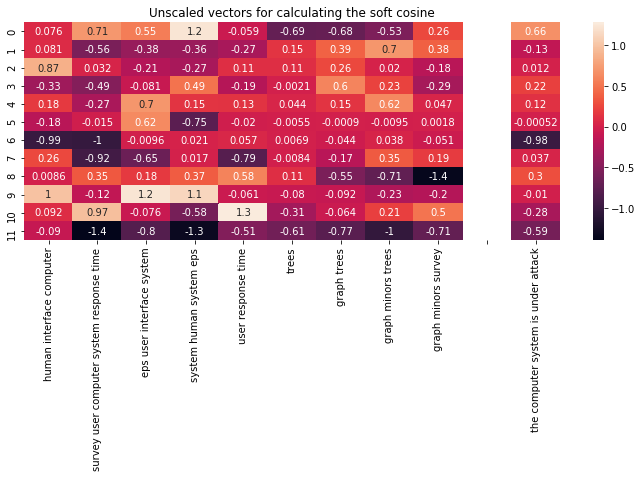

In [56]:
sns.heatmap(
    np.concatenate([simple_docv,
                    np.zeros_like(sysattack_query),
                    sysattack_query],
                    axis=1),
    mask=np.concatenate([np.zeros_like(simple_docv),
                         np.ones_like(sysattack_query),
                         np.zeros_like(sysattack_query)],
                         axis=1),
    annot=True,
    ax=plt.subplots(figsize=(12, 4))[1],
    xticklabels=[" ".join(wlist) for wlist in common_texts] +
                ["", sysattack_msg],
).set(title="Unscaled vectors for calculating the soft cosine");

We can calculate the soft cosine similarities as before,
using the new matrices,

$$
\cos_{\Lambda}(X_U, Y_U) =
  \dfrac{X_U^T \Lambda Y_U}{\sqrt{X_U^T \Lambda X_U}
                            \sqrt{Y_U^T \Lambda Y_U}}
$$

The new matrix $\Lambda$ is diagonal,
perhaps with negative entries (not in this example).
We'll find the same results,
we've just segregated the scaling factor from the rotation/shearing.

In [57]:
ss_alt = (
    sysattack_query.T * simple_eigvals @ simple_docv /
    np.sqrt(
        np.sum(simple_docv.T ** 2 * simple_eigvals, axis=1) *
        np.sum(sysattack_query.ravel() ** 2 * simple_eigvals)
    )
).ravel()
ss_alt

array([0.4077974 , 0.5745108 , 0.35381803, 0.5766434 , 0.00142215,
       0.03644096, 0.02576766, 0.02205063, 0.0037755 ], dtype=float32)

In [58]:
np.isclose(sysattack_similarities, ss_alt)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])